In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
import seaborn as sns

## Load Data

In [4]:
df1 = pd.read_csv('loan_2016.csv')

C:\Users\Weiqun\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2718: DtypeWarning: Columns (16,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df1.shape

(434407, 108)

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434407 entries, 0 to 434406
Columns: 108 entries, secappopenactil to loanstatus
dtypes: float64(88), int64(1), object(19)
memory usage: 357.9+ MB


## Select Data

In [7]:
all_null_feature =['secappopenactil',
 'secappnumrevaccts',
 'secappmthssincelastmajorderog',
 'secappcollections12mthsexmed',
 'revolbaljoint',
 'secappopenacc',
 'secappficorangelow',
 'memberid',
 'secappmortacc',
 'secappearliestcrline',
 'secappchargeoffwithin12mths',
 'secapprevolutil',
 'secappficorangehigh',
 'secappinqlast6mths']

In [8]:
ob_feature=['initialliststatus',
 'grade',
 'subgrade',
 'verificationstatusjoint',
 'earliestcrline',
 'applicationtype',
 'intrate',
 'desc',
 'term',
 'homeownership',
 'addrstate',
 'revolutil',
 'zipcode',
 'verificationstatus',
 'emptitle',
 'emplength',
 'purpose',
 'issued',
 'loanstatus']

In [9]:
num_feature=['bcopentobuy',
 'numactvbctl',
 'mthssincelastrecord',
 'totcurbal',
 'mosinrcnttl',
 'openrv12m',
 'inqlast12m',
 'mortacc',
 'mthssincelastdelinq',
 'numactvrevtl',
 'tothicredlim',
 'ficorangehigh',
 'maxbalbc',
 'openil24m',
 'numbctl',
 'totalrevhilim',
 'totcollamt',
 'numtl120dpd2m',
 'totalbalexmort',
 'annualincjoint',
 'ficorangelow',
 'totalacc',
 'mthssincerecentbcdlq',
 'installment',
 'numrevaccts',
 'pubrec',
 'accopenpast24mths',
 'numoprevtl',
 'avgcurbal',
 'openactil',
 'dti',
 'openacc6m',
 'totalbalil',
 'delinq2yrs',
 'fundedamnt',
 'mosinoldilacct',
 'annualinc',
 'inqfi',
 'numtl30dpd',
 'loanamnt',
 'numsats',
 'mthssincerecentrevoldelinq',
 'mthssincerecentbc',
 'id',
 'revolbal',
 'inqlast6mths',
 'mthssincercntil',
 'openrv24m',
 'totalilhighcreditlimit',
 'collections12mthsexmed',
 'chargeoffwithin12mths',
 'numtl90gdpd24m',
 'delinqamnt',
 'mosinoldrevtlop',
 'taxliens',
 'numbcsats',
 'totalbclimit',
 'dtijoint',
 'numacctsever120pd',
 'accnowdelinq',
 'openil12m',
 'pcttlnvrdlq',
 'bcutil',
 'mthssincerecentinq',
 'numiltl',
 'mosinrcntrevtlop',
 'allutil',
 'openacc',
 'numrevtlbalgt0',
 'totalcutl',
 'mthssincelastmajorderog',
 'numtloppast12m',
 'percentbcgt75',
 'pubrecbankruptcies',
 'ilutil']

In [10]:
select_feature=ob_feature+num_feature
len(select_feature)

94

In [11]:
# remove fundedamnt since it always equals to 1 for issued loans and varied during different time of a current loan

num_feature.remove('fundedamnt')


In [12]:
# remove 'id','issued' and 'loanstatus', since they are index, train/test flag and target
num_feature.remove('id')
ob_feature.remove('loanstatus')
ob_feature.remove('issued')


In [13]:
# remove 'desc' from ob_feature and select_feature
ob_feature.remove('desc')


In [14]:
select_feature=ob_feature+num_feature
len(select_feature)

89

In [15]:
# selected features left
df=df1[select_feature+['id','loanstatus','issued']]

In [16]:
df.shape

(434407, 92)

## only use term=36 months and loanstatus = fully paid and charged off

In [17]:
df = df.query("loanstatus == 'Fully Paid' or loanstatus == 'Charged Off' ")

In [18]:
df = df.query("term ==' 36 months'")

In [19]:
df.shape

(295807, 92)

In [20]:
df.drop('term', axis = 1, inplace=True)

In [21]:
df.shape

(295807, 91)

In [22]:
ob_feature.remove('term')

## Label Target

In [23]:
df['loanstatus'] = df.loanstatus.map({"Charged Off": 1, "Fully Paid": 0})

In [24]:
print df.loanstatus.value_counts()
print df.loanstatus.value_counts(normalize=True)

0    245786
1     50021
Name: loanstatus, dtype: int64
0    0.8309
1    0.1691
Name: loanstatus, dtype: float64


## Out of time testing set and in-time training set: Oct~Dec as test)

In [25]:
issued=list(df['issued'].unique())
issued

['Mar-2016',
 'Feb-2016',
 'Jan-2016',
 'Jun-2016',
 'May-2016',
 'Apr-2016',
 'Sep-2016',
 'Aug-2016',
 'Jul-2016',
 'Dec-2016',
 'Nov-2016',
 'Oct-2016']

In [26]:
df['train_flg'] = df.issued.apply(lambda x: 0 if x in ['Oct-2016','Nov-2016','Dec-2016'] else 1)
df.train_flg.value_counts()

1    241114
0     54693
Name: train_flg, dtype: int64

In [27]:
df.drop('issued', axis = 1, inplace=True)

In [28]:
df.shape

(295807, 91)

## Feature Engineering & Cleaning

#### Datetime to numeric feature

In [29]:
df.earliestcrline.unique()[:5]

array(['May-2006', 'Dec-2001', 'Sep-2008', 'May-1990', 'Feb-2006'], dtype=object)

In [30]:
# convert to number of months to Dec 2016

In [31]:
cl_month=df.earliestcrline.apply(lambda x: x.split('-')[0])
cl_year=df.earliestcrline.apply(lambda x: int(x.split('-')[1]))

In [32]:
cl_month.unique()

array(['May', 'Dec', 'Sep', 'Feb', 'Nov', 'Mar', 'Jul', 'Jan', 'Apr',
       'Jun', 'Aug', 'Oct'], dtype=object)

In [33]:
cl_year.unique()

array([2006, 2001, 2008, 1990, 1994, 2012, 1999, 1986, 2005, 2002, 1995,
       2010, 1993, 2003, 2007, 2009, 1992, 2004, 1975, 1997, 1985, 1996,
       2000, 2011, 1981, 1998, 1980, 1989, 1983, 1991, 1982, 1988, 1987,
       1972, 2013, 1978, 1984, 1976, 1963, 1969, 1979, 1973, 1974, 1977,
       1971, 1970, 1966, 1967, 1968, 1965, 1955, 1960, 1957, 1961, 1964,
       1958, 1959, 1962, 1956, 1948, 1952, 1933, 1954, 1946, 1951], dtype=int64)

In [34]:
dic_month= {'Jan':11,'Feb':10,'Mar':9,'Apr':8, 'May':7, 'Jun':6, 'Jul':5, 'Aug':4, 'Sep':3, 'Oct':2, 'Nov':1, 'Dec':0}

In [35]:
df['earliestcrline_month']=df.earliestcrline.apply(lambda x: (2016-int(x.split('-')[1]))*12+dic_month[x.split('-')[0]])

In [36]:
df.earliestcrline_month[:5]

0    127
2    180
5     99
7    319
8    130
Name: earliestcrline_month, dtype: int64

In [37]:
num_feature.append('earliestcrline_month')
ob_feature.remove('earliestcrline')


In [38]:
print len(ob_feature), len(num_feature)

14 74


In [39]:
df.drop('earliestcrline', axis = 1, inplace=True)

In [40]:
df.shape

(295807, 91)

### emplength to numeric feature

In [41]:
print df['emplength'].isnull().sum()
df['emplength'].unique()

0


array(['9 years', '10+ years', '5 years', 'n/a', '2 years', '< 1 year',
       '1 year', '3 years', '8 years', '6 years', '7 years', '4 years'], dtype=object)

In [42]:
df['emplength'].replace('n/a', np.nan, inplace=True)
df['emplength'].replace('< 1 year', '0', inplace=True)
df['emplength'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
df.emplength.fillna(value=-999,inplace=True)
df['emplength'] = df['emplength'].astype(int)

In [43]:
df.emplength.value_counts()

 10     97261
 2      27689
 3      24299
 0      22739
-999    21320
 1      20468
 5      18143
 4      17691
 8      12680
 6      12677
 9      11293
 7       9547
Name: emplength, dtype: int64

In [44]:
num_feature.append('emplength')
ob_feature.remove('emplength')
print len(num_feature), len(ob_feature)

75 13


In [45]:
df.shape

(295807, 91)

## % to numeric feature: intrate, revolutil

In [46]:
intrate=df.intrate.apply(lambda x: float(x.replace('%','')))

In [47]:
df.intrate=intrate
df.intrate[:2]

0    12.99
2     5.32
Name: intrate, dtype: float64

In [48]:
df.revolutil = pd.Series(df.revolutil).str.replace('%', '').astype(float)

In [49]:
df.revolutil[:2]

0    63.0
2    18.4
Name: revolutil, dtype: float64

In [50]:
ob_feature.remove('intrate')
num_feature.append('intrate')
ob_feature.remove('revolutil')
num_feature.append('revolutil')

In [51]:
print len(ob_feature), len(num_feature)

11 77


#### Ordinal feature encoding : grade, subgrade

In [52]:
Dic_grade = {"A": 1, 
            "B": 2, 
            "C": 3, 
            "D": 4, 
            "E": 5,
            "F": 6, 
            "G": 7}

In [53]:
df.grade = df.grade.map(Dic_grade)

In [54]:
df.subgrade = df.subgrade.apply(lambda x: (Dic_grade[x[0]] - 1) * 5 + int(x[1]))

In [55]:
ob_feature.remove('grade')
num_feature.append('grade')
ob_feature.remove('subgrade')
num_feature.append('subgrade')

In [56]:
print len(ob_feature), len(num_feature)

9 79


### High cardinality feature encoding

###### Zip Code - frequency encoding 

In [57]:
print df.zipcode.nunique(), df.zipcode.unique()[:5]

903 ['211xx' '554xx' '328xx' '163xx' '117xx']


In [58]:
# convert zipcode to int
df.zipcode = df.zipcode.apply(lambda x: int(x[0:3]))

In [59]:
zipcode_freq = df.groupby("zipcode").size().reset_index()

In [60]:
zipcode_freq[:5]

,zipcode,0
0,8,2
1,9,1
2,10,461
3,11,155
4,12,106


In [61]:
zipcode_freq.columns = ["zipcode", "zipcode_freq"]

In [62]:
df = pd.merge(df, zipcode_freq, how = "left", on = "zipcode")

In [63]:
ob_feature.remove('zipcode')
num_feature.append('zipcode_freq')
num_feature.append('zipcode')
print len(ob_feature), len(num_feature)

8 81


### emptitle-frequency encoding (can do some NLP for later stage)

In [64]:
emptitle_freq = df.groupby("emptitle").size().reset_index()
emptitle_freq.columns = ["emptitle", "emptitle_freq"]
df = pd.merge(df, emptitle_freq, how = "left", on = "emptitle")


In [65]:
df.drop("emptitle", axis = 1, inplace=True)

In [66]:
ob_feature.remove('emptitle')
num_feature.append('emptitle_freq')
print len(ob_feature), len(num_feature)

7 82


###### Addr_state - frequency encoding

In [67]:
addrstate_freq = df.groupby("addrstate").size().reset_index()
addrstate_freq.columns = ["addrstate", "addrstate_freq"]
df = pd.merge(df, addrstate_freq, how = "left", on = "addrstate")


In [70]:
df.drop("addrstate", axis = 1, inplace=True)

In [71]:
ob_feature.remove('addrstate')
num_feature.append('addrstate_freq')
print len(ob_feature), len(num_feature)

6 83


Binary features

In [72]:
ob_feature

['initialliststatus',
 'verificationstatusjoint',
 'applicationtype',
 'homeownership',
 'verificationstatus',
 'purpose']

In [73]:
# initialliststatus has only two values, change it to 0,1
initialliststatus= df.initialliststatus.apply(lambda x: 0 if x =='w' else 1)
df.initialliststatus = initialliststatus
df.initialliststatus.value_counts()

0    217986
1     77821
Name: initialliststatus, dtype: int64

In [74]:
# applicationtype has only two values (Individual, Joint), change it to 0,1; only less than 2% is 1.
applicationtype= df.applicationtype.apply(lambda x: 0 if x =='Individual' else 1)
df.applicationtype = applicationtype 
df.applicationtype.value_counts()

0    291419
1      4388
Name: applicationtype, dtype: int64

In [75]:
ob_feature.remove('initialliststatus')
num_feature.append('initialliststatus')
ob_feature.remove('applicationtype')
num_feature.append('applicationtype')
print len(ob_feature), len(num_feature), ob_feature

4 85 ['verificationstatusjoint', 'homeownership', 'verificationstatus', 'purpose']


In [76]:
# verificationstatusjoint mostly consistent with applicationtype, just remove it
ob_feature.remove('verificationstatusjoint')
print len(ob_feature), len(num_feature), ob_feature

3 85 ['homeownership', 'verificationstatus', 'purpose']


#### One hot encoding

In [77]:
dummy_feature = ["homeownership", "verificationstatus", "purpose"]

In [78]:
df_dummy = pd.get_dummies(df[dummy_feature])

In [79]:
OHE_feature=list(df_dummy.columns.values)

In [80]:
df_dummy.shape

(295807, 20)

In [81]:
df=pd.concat([df,df_dummy], axis=1 )

In [82]:
df.shape

(295807, 112)

In [83]:
df.drop(dummy_feature, axis = 1, inplace=True)

In [84]:
df.shape

(295807, 109)

In [85]:
for feat in dummy_feature:
    
    ob_feature.remove(feat)

In [86]:
select_feature=num_feature+OHE_feature

In [87]:
len(select_feature)

105

##  XGBoost 

In [88]:
feat=select_feature
print feat

['bcopentobuy', 'numactvbctl', 'mthssincelastrecord', 'totcurbal', 'mosinrcnttl', 'openrv12m', 'inqlast12m', 'mortacc', 'mthssincelastdelinq', 'numactvrevtl', 'tothicredlim', 'ficorangehigh', 'maxbalbc', 'openil24m', 'numbctl', 'totalrevhilim', 'totcollamt', 'numtl120dpd2m', 'totalbalexmort', 'annualincjoint', 'ficorangelow', 'totalacc', 'mthssincerecentbcdlq', 'installment', 'numrevaccts', 'pubrec', 'accopenpast24mths', 'numoprevtl', 'avgcurbal', 'openactil', 'dti', 'openacc6m', 'totalbalil', 'delinq2yrs', 'mosinoldilacct', 'annualinc', 'inqfi', 'numtl30dpd', 'loanamnt', 'numsats', 'mthssincerecentrevoldelinq', 'mthssincerecentbc', 'revolbal', 'inqlast6mths', 'mthssincercntil', 'openrv24m', 'totalilhighcreditlimit', 'collections12mthsexmed', 'chargeoffwithin12mths', 'numtl90gdpd24m', 'delinqamnt', 'mosinoldrevtlop', 'taxliens', 'numbcsats', 'totalbclimit', 'dtijoint', 'numacctsever120pd', 'accnowdelinq', 'openil12m', 'pcttlnvrdlq', 'bcutil', 'mthssincerecentinq', 'numiltl', 'mosinrcnt

In [89]:
len(feat)

105

### Preliminary manually parameter tuning based on stratified train-test split

In [90]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split
#Kfolds = StratifiedKFold(df_all['loan_status'], n_folds = 3, shuffle=True, random_state=2019)

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [91]:
df_train = df.query("train_flg == 1")
df_test =df.query("train_flg == 0" )

In [92]:
print df_train.shape, df_test.shape

(241114, 109) (54693, 109)


In [93]:
X_train, X_valid, y_train, y_valid = train_test_split(df_train[feat], df_train.loanstatus, 
                                                      test_size=0.3, random_state=2016, stratify = df_train.loanstatus )

In [94]:
X_test, y_test = df_test[feat], df_test.loanstatus

In [95]:
dtrain = xgb.DMatrix(X_train, y_train, missing = np.NAN)
dvalid = xgb.DMatrix(X_valid, y_valid, missing = np.NAN)
dtest = xgb.DMatrix(X_test, y_test, missing = np.NAN)

In [96]:
params = {"objective": "binary:logistic", 
          "booster" : "gbtree", 
          "eta": 0.05, 
          "max_depth": 6, 
          "subsample": 0.632, 
          "colsample_bytree": 0.7,
          #"colsample_bylevel": 0.6,
          "silent": 1, 
          "seed": 1441, 
          "eval_metric": "auc",
          #"gamma": 1, 
          "min_child_weight": 5} # 74453

In [97]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
num_boost_round = 1500
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist,\
  early_stopping_rounds= 50)

[0]	train-auc:0.692116	eval-auc:0.682509
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[1]	train-auc:0.699085	eval-auc:0.68796
[2]	train-auc:0.701914	eval-auc:0.690532
[3]	train-auc:0.703703	eval-auc:0.691422
[4]	train-auc:0.704266	eval-auc:0.691852
[5]	train-auc:0.705514	eval-auc:0.69261
[6]	train-auc:0.705955	eval-auc:0.692824
[7]	train-auc:0.706737	eval-auc:0.69323
[8]	train-auc:0.707033	eval-auc:0.693415
[9]	train-auc:0.707489	eval-auc:0.693698
[10]	train-auc:0.708018	eval-auc:0.69398
[11]	train-auc:0.708269	eval-auc:0.694131
[12]	train-auc:0.708493	eval-auc:0.694118
[13]	train-auc:0.708828	eval-auc:0.694379
[14]	train-auc:0.709197	eval-auc:0.694551
[15]	train-auc:0.709535	eval-auc:0.694637
[16]	train-auc:0.709836	eval-auc:0.694727
[17]	train-auc:0.710082	eval-auc:0.694859
[18]	train-auc:0.710455	eval-auc:0.695217
[19]	train-auc:0.710955	eval-auc:0.695383
[20]	train-auc:0.711363	eval-auc:

[191]	train-auc:0.763254	eval-auc:0.708572
[192]	train-auc:0.763509	eval-auc:0.708572
[193]	train-auc:0.763685	eval-auc:0.708606
[194]	train-auc:0.763814	eval-auc:0.708601
[195]	train-auc:0.763955	eval-auc:0.708592
[196]	train-auc:0.764114	eval-auc:0.70861
[197]	train-auc:0.764359	eval-auc:0.708649
[198]	train-auc:0.76465	eval-auc:0.708779
[199]	train-auc:0.764914	eval-auc:0.708767
[200]	train-auc:0.765139	eval-auc:0.708808
[201]	train-auc:0.765302	eval-auc:0.708769
[202]	train-auc:0.765551	eval-auc:0.708738
[203]	train-auc:0.765803	eval-auc:0.708788
[204]	train-auc:0.765913	eval-auc:0.708768
[205]	train-auc:0.766057	eval-auc:0.70875
[206]	train-auc:0.766236	eval-auc:0.708741
[207]	train-auc:0.766396	eval-auc:0.708731
[208]	train-auc:0.766537	eval-auc:0.708728
[209]	train-auc:0.766742	eval-auc:0.708744
[210]	train-auc:0.766979	eval-auc:0.708688
[211]	train-auc:0.767119	eval-auc:0.708645
[212]	train-auc:0.767455	eval-auc:0.708678
[213]	train-auc:0.767776	eval-auc:0.708668
[214]	train-au

In [98]:
from sklearn.metrics import roc_curve, auc
from sklearn import linear_model, datasets
import pylab as pl
def draw_ROC(model, dtrain, dvalid, dtest, y_train, y_valid, y_test ):
    probas_ = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
    probas_1 = model.predict(dtrain, ntree_limit=model.best_ntree_limit)
    probas_2 = model.predict(dtest, ntree_limit=model.best_ntree_limit)
    fpr, tpr, thresholds = roc_curve(y_valid, probas_)
    fpr_1, tpr_1, thresholds_1 = roc_curve(y_train, probas_1)
    fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, probas_2)
    roc_auc = auc(fpr, tpr)
    roc_auc_1 = auc(fpr_1, tpr_1)
    roc_auc_2 = auc(fpr_2, tpr_2)
    print "Area under the ROC curve - validation: %f" % roc_auc
    print "Area under the ROC curve - train: %f" % roc_auc_1
    print "Area under the ROC curve - test: %f" % roc_auc_2
    # Plot ROC curve
    plt.figure(figsize=(8,8))
    plt.plot(fpr, tpr, label='ROC curve - valid(AUC = %0.2f)' % roc_auc, color='r')
    plt.plot(fpr_1, tpr_1, label='ROC curve - train (AUC = %0.2f)' % roc_auc_1, color='b')
    plt.plot(fpr_2, tpr_2, label='ROC curve - test (AUC = %0.2f)' % roc_auc_2, color='g')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for lead score model')
    plt.legend(loc="lower right")
    plt.show()


### ROC curve

Area under the ROC curve - validation: 0.709152
Area under the ROC curve - train: 0.775985
Area under the ROC curve - test: 0.693134


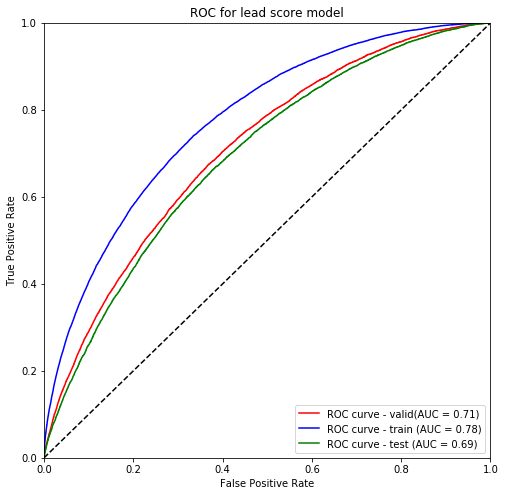

In [99]:
draw_ROC(gbm, dtrain, dvalid, dtest, y_train, y_valid, y_test)

### Distribution of predicted values

In [100]:
y_pred = gbm.predict(dtest)

In [101]:
print y_pred.max(), y_pred.min(), y_pred.mean()

0.858688 0.00631137 0.169288


### Feature importance

In [102]:
importance=gbm.get_fscore()

In [103]:
df_importance = pd.DataFrame(importance.items(), columns=['feature', 'fscore'])
df_importance['fscore'] = df_importance['fscore'] / df_importance['fscore'].sum()

In [104]:
df_importance.sort_values(['fscore'], ascending=False, inplace=True)
df_importance

,feature,fscore
63,dti,0.033108
26,installment,0.031230
83,zipcode,0.028587
14,maxbalbc,0.028240
41,mosinoldrevtlop,0.026918
29,mosinoldilacct,0.026083
96,emptitle_freq,0.025736
62,intrate,0.025179
30,annualinc,0.025040
36,mthssincercntil,0.023371


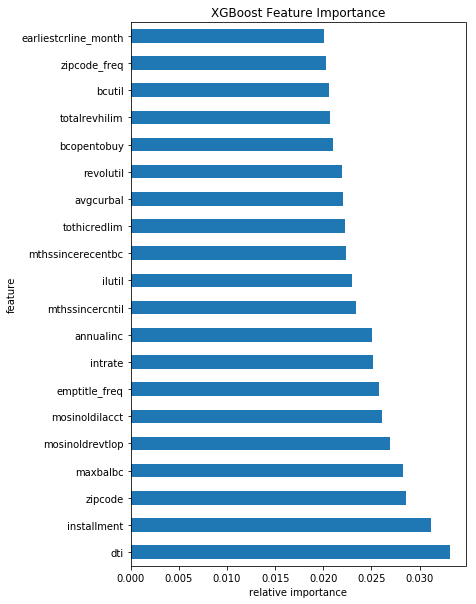

In [105]:
plt.figure(figsize=(32, 32))
# df_importance.plot()
df_importance[:20].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('feature_importance_xgb.png')

In [106]:
grade_importance = df_importance.query("feature=='grade'")
grade_importance

,feature,fscore
51,grade,0.003617


In [107]:
subgrade_importance = df_importance.query("feature=='subgrade'")
subgrade_importance

,feature,fscore
5,subgrade,0.010572


In [108]:
intrate_importance = df_importance.query("feature=='intrate'")
intrate_importance

,feature,fscore
62,intrate,0.025179


In [109]:
df_importance.query("feature=='loanamnt'")

,feature,fscore
24,loanamnt,0.018571


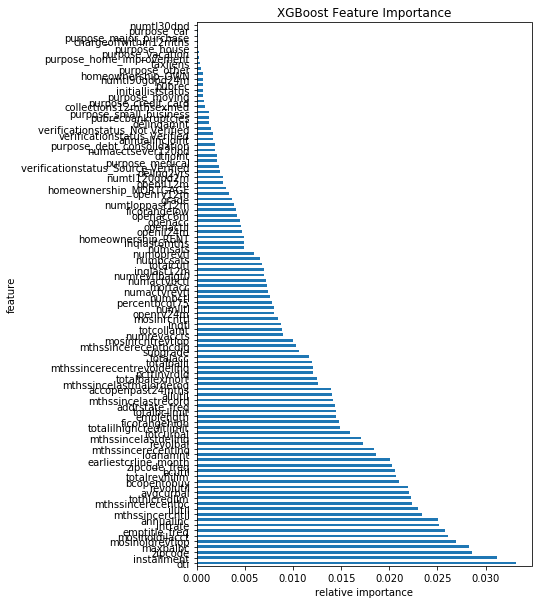

In [110]:
plt.figure(figsize=(32, 32))
# df_importance.plot()
df_importance.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

## Hyperparameter Tuning - Bayesian Optimization

In [111]:
from bayes_opt import BayesianOptimization

train_x = df_train[feat]
train_y = df_train.loanstatus

xgtrain = xgb.DMatrix(train_x, label=train_y, missing = np.NAN)  

def xgb_evaluate(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma):
    params = dict()
    params['objective'] = 'binary:logistic'
    params['eta'] = 0.05
    params['max_depth'] = int(max_depth )   
    params['min_child_weight'] = int(min_child_weight)
    params['colsample_bytree'] = colsample_bytree
    params['subsample'] = subsample
    params['gamma'] = gamma
    params['verbose_eval'] = False 



    cv_result = xgb.cv(params, xgtrain,
                       num_boost_round=100000,
                       nfold=3,
                       metrics={'auc'},
                       seed=1234,
                       callbacks=[xgb.callback.early_stop(50)])
    print(cv_result)

    return cv_result['test-auc-mean'].max()


xgb_BO = BayesianOptimization(xgb_evaluate, 
                             {'max_depth': (4, 8),
                              'min_child_weight': (0, 20),
                              'colsample_bytree': (0.2, 0.8),
                              'subsample': (0.5, 1),
                              'gamma': (0, 2)
                             }
                            )

xgb_BO.maximize(init_points=5, n_iter=40)

Initialization
---------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   subsample | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[309]	train-auc:0.813584+0.000386205	test-auc:0.710519+0.00203911

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.629466      0.001563        0.648475       0.001698
1         0.658169      0.020064        0.680800       0.014891
2         0.671525      0.013625        0.695024       0.011603
3         0.675609      0.015476        0.700707       0.012991
4         0.683844      0.008362        0.708599       0.004802
5         0.687250      0.008840        0.712539       0.006055
6         0.689683      0.009768        0.715390       0.006463
7         0.69

Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[355]	train-auc:0.787283+0.000543613	test-auc:0.710963+0.00145976

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.682884      0.000548        0.692142       0.000756
1         0.688858      0.001737        0.699312       0.001122
2         0.691224      0.001533        0.701108       0.000921
3         0.692337      0.001337        0.702457       0.000826
4         0.692722      0.001448        0.703195       0.000811
5         0.693394      0.001304        0.704132       0.000908
6         0.693852      0.001212        0.704704       0.000983
7         0.694111      0.001098        0.705396       0.001276
8         0.694498      0.001180        0.706054       0.001227
9         0.694945      0.001119        0.706570       0.001260
10        0.695332      0.001206        0.707104       0.00122

Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[318]	train-auc:0.788864+0.00105157	test-auc:0.710539+0.00173563

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.683898      0.001621        0.692513       0.000538
1         0.688835      0.001870        0.699323       0.001001
2         0.690832      0.001606        0.701167       0.000985
3         0.691850      0.001269        0.702316       0.001241
4         0.692551      0.001439        0.703069       0.001202
5         0.693460      0.001356        0.704173       0.001217
6         0.693695      0.001389        0.704819       0.001193
7         0.694120      0.001377        0.705332       0.001300
8         0.694512      0.001419        0.705889       0.001143
9         0.694884      0.001297        0.706568       0.001179
10        0.695232      0.001344        0.707168       0.001123

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\Weiqun\Anaconda2\lib\site-packages\bayesian_optimization-0.3.0-py2.7.egg\bayes_opt\helpers.py:95: RuntimeWarning: divide by zero encountered in true_divide


Bayesian Optimization
---------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   subsample | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[618]	train-auc:0.748795+0.000905303	test-auc:0.711845+0.00182202

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.623274      0.002904        0.628479       0.001188
1         0.652143      0.024957        0.657561       0.021068
2         0.670882      0.020856        0.674673       0.018329
3         0.675983      0.023636        0.679654       0.020989
4         0.686467      0.010290        0.689981       0.008042
5         0.687007      0.011896        0.690228       0.009825
6         0.688427      0.010833        0.691799       0.008657
7      

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  5.67094526e-05]), 'nit': 5, 'funcalls': 48}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -2.31001247e-05]), 'nit': 4, 'funcalls': 49}
  " state: %s" % convergence_dict)


    6 | 06m26s |    0.71184 |             0.2452 |    0.1752 |      4.1582 |            14.5404 |      0.7006 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[407]	train-auc:0.76037+0.00101727	test-auc:0.711359+0.00191035

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.681500      0.001227        0.686793       0.000688
1         0.687194      0.001273        0.692678       0.000705
2         0.689637      0.000837        0.694785       0.001146
3         0.690484      0.000980        0.695787       0.001301
4         0.691058      0.001282        0.696372       0.001098
5         0.691453      0.001723        0.696788       0.000847
6         0.691922      0.001557        0.697405       0.000763
7         0.692344      0.001511        0.697996       0.000863
8         0.692815      0.001651        0.698547       0.000791
9         0.693

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  7.56706568e-05]), 'nit': 5, 'funcalls': 52}
  " state: %s" % convergence_dict)


    8 | 07m55s |    0.71128 |             0.6462 |    0.0750 |      4.0528 |             5.2399 |      0.7505 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[409]	train-auc:0.762843+0.00102967	test-auc:0.711301+0.00190897

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.682194      0.001876        0.686311       0.000176
1         0.687911      0.001017        0.692282       0.001091
2         0.689980      0.000693        0.694508       0.000931
3         0.690922      0.000762        0.695722       0.000978
4         0.691555      0.000946        0.696643       0.000826
5         0.692039      0.001049        0.697300       0.000887
6         0.692421      0.001359        0.697863       0.000939
7         0.692882      0.001214        0.698278       0.000947
8         0.693120      0.001254        0.698578       0.000831
9         0.69

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -3.60636163e-05]), 'nit': 5, 'funcalls': 53}
  " state: %s" % convergence_dict)


    9 | 07m30s |    0.71130 |             0.7006 |    0.0975 |      5.0250 |            10.0649 |      0.5033 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[630]	train-auc:0.754646+0.000929986	test-auc:0.711725+0.00180225

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.680878      0.001571        0.682735       0.000707
1         0.685417      0.001200        0.687504       0.000906
2         0.686405      0.001334        0.688668       0.000565
3         0.686693      0.001410        0.688902       0.000524
4         0.687101      0.000951        0.689470       0.000937
5         0.687655      0.001302        0.690115       0.000717
6         0.688163      0.001384        0.690658       0.000633
7         0.688718      0.001130        0.691109       0.000845
8         0.689079      0.001259        0.691545       0.000838
9         0.6

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.44904097e-05]), 'nit': 8, 'funcalls': 58}
  " state: %s" % convergence_dict)


   10 | 09m33s |    0.71172 |             0.7315 |    0.4589 |      4.0662 |            15.0417 |      0.8345 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[465]	train-auc:0.782644+0.001419	test-auc:0.711098+0.00170107

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.684167      0.001170        0.687752       0.000561
1         0.688849      0.001530        0.693204       0.000934
2         0.689916      0.001515        0.694495       0.000605
3         0.690482      0.001272        0.695070       0.000773
4         0.690911      0.001300        0.695748       0.000928
5         0.691089      0.001498        0.696343       0.000776
6         0.691516      0.001289        0.697115       0.000824
7         0.691998      0.001161        0.697671       0.001042
8         0.692384      0.001311        0.698162       0.000940
9         0.6926

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00070419]), 'nit': 6, 'funcalls': 52}
  " state: %s" % convergence_dict)


   11 | 08m58s |    0.71110 |             0.7841 |    0.2256 |      5.2929 |             0.9492 |      0.8167 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[717]	train-auc:0.753641+0.000746377	test-auc:0.711985+0.00193728

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.623274      0.002904        0.628479       0.001188
1         0.652143      0.024957        0.657561       0.021068
2         0.670882      0.020856        0.674673       0.018329
3         0.675983      0.023636        0.679654       0.020989
4         0.686467      0.010290        0.689981       0.008042
5         0.687007      0.011896        0.690228       0.009825
6         0.688427      0.010833        0.691799       0.008657
7         0.688160      0.011057        0.691304       0.008870
8         0.687990      0.010711        0.691103       0.008458
9         0.6

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00371804]), 'nit': 5, 'funcalls': 70}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.13633268e-05]), 'nit': 6, 'funcalls': 65}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00034891]), 'nit': 10, 'funcalls': 120}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs

   12 | 06m58s |    0.71198 |             0.2452 |    0.1752 |      4.1582 |            14.5404 |      0.7006 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[463]	train-auc:0.782479+0.00144139	test-auc:0.710979+0.00166196

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.684167      0.001170        0.687752       0.000561
1         0.688849      0.001530        0.693204       0.000934
2         0.689916      0.001515        0.694495       0.000605
3         0.690482      0.001272        0.695070       0.000773
4         0.690911      0.001300        0.695748       0.000928
5         0.691089      0.001498        0.696343       0.000776
6         0.691516      0.001289        0.697115       0.000824
7         0.691998      0.001161        0.697671       0.001042
8         0.692384      0.001311        0.698162       0.000940
9         0.69

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.04154321]), 'nit': 6, 'funcalls': 55}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.03959589]), 'nit': 7, 'funcalls': 58}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.03967022]), 'nit': 6, 'funcalls': 55}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b term

   13 | 09m14s |    0.71098 |             0.7841 |    0.2256 |      5.2929 |             0.9492 |      0.8167 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[236]	train-auc:0.821197+0.00019314	test-auc:0.710019+0.00149624

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.684468      0.002494        0.696998       0.000312
1         0.689256      0.002151        0.704364       0.000312
2         0.691952      0.001793        0.707931       0.000891
3         0.692692      0.001729        0.709621       0.001080
4         0.693181      0.001806        0.711064       0.001119
5         0.694167      0.001468        0.713703       0.002081
6         0.694693      0.001269        0.715045       0.002355
7         0.695060      0.001193        0.715793       0.002386
8         0.695388      0.001244        0.716765       0.002194
9         0.69

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -3.86972970e-05]), 'nit': 7, 'funcalls': 118}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00013672]), 'nit': 6, 'funcalls': 55}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.03679865]), 'nit': 6, 'funcalls': 85}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_

   14 | 05m18s |    0.71002 |             0.5506 |    0.2740 |      7.3032 |             0.6537 |      0.8505 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[328]	train-auc:0.788881+0.00139049	test-auc:0.710308+0.00191123

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.683944      0.001776        0.692762       0.000174
1         0.689016      0.002227        0.698661       0.000025
2         0.691388      0.001523        0.701123       0.000385
3         0.692167      0.001680        0.701906       0.000396
4         0.692963      0.001597        0.702917       0.000629
5         0.693471      0.001706        0.703732       0.000699
6         0.694032      0.001427        0.704531       0.000798
7         0.694272      0.001365        0.705064       0.000880
8         0.694638      0.001476        0.705769       0.000894
9         0.69

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00063857]), 'nit': 6, 'funcalls': 69}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00015612]), 'nit': 8, 'funcalls': 76}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00068501]), 'nit': 5, 'funcalls': 70}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b term

   15 | 06m08s |    0.71031 |             0.5542 |    0.4247 |      6.7351 |             5.4457 |      0.8320 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[541]	train-auc:0.767096+0.00111212	test-auc:0.711631+0.00186475

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.624831      0.001214        0.632868       0.001299
1         0.657966      0.021474        0.666913       0.017686
2         0.671896      0.015836        0.679873       0.014517
3         0.678293      0.019186        0.685425       0.017673
4         0.687042      0.008063        0.694295       0.006240
5         0.688476      0.009668        0.695506       0.007975
6         0.690450      0.009640        0.697424       0.007712
7         0.690410      0.009949        0.697151       0.007925
8         0.690064      0.010245        0.696869       0.007784
9         0.68

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00168827]), 'nit': 6, 'funcalls': 72}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00768543]), 'nit': 4, 'funcalls': 50}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00108983]), 'nit': 6, 'funcalls': 63}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b term

   16 | 05m48s |    0.71163 |             0.2309 |    0.0928 |      5.8508 |            16.0089 |      0.8815 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[380]	train-auc:0.761466+0.000611041	test-auc:0.711374+0.00174958

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.682423      0.000711        0.687041       0.000795
1         0.687626      0.001527        0.692543       0.001163
2         0.689286      0.001298        0.694088       0.000835
3         0.690368      0.001203        0.695244       0.000719
4         0.691214      0.001152        0.696200       0.000841
5         0.691538      0.001137        0.696722       0.000813
6         0.691927      0.001192        0.697279       0.000845
7         0.692371      0.001043        0.697844       0.001093
8         0.692804      0.000988        0.698313       0.001031
9         0.6

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -3.15160072e-05]), 'nit': 9, 'funcalls': 56}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00207439]), 'nit': 7, 'funcalls': 82}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.03308052]), 'nit': 4, 'funcalls': 54}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b

   17 | 07m52s |    0.71137 |             0.7822 |    1.2062 |      5.0524 |            13.8779 |      0.6362 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[578]	train-auc:0.754822+0.000899342	test-auc:0.711573+0.0020525

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.680512      0.000784        0.682116       0.000659
1         0.685363      0.000969        0.687776       0.000981
2         0.686969      0.000779        0.689195       0.001028
3         0.687974      0.000669        0.690194       0.001246
4         0.688196      0.000824        0.690709       0.001189
5         0.688632      0.001287        0.691210       0.000901
6         0.688792      0.001481        0.691532       0.000749
7         0.689354      0.001401        0.692105       0.000889
8         0.689748      0.001478        0.692463       0.000771
9         0.69

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00150184]), 'nit': 5, 'funcalls': 68}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00230376]), 'nit': 6, 'funcalls': 91}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.04203748]), 'nit': 6, 'funcalls': 83}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b term

   18 | 08m27s |    0.71157 |             0.6562 |    1.2267 |      4.1104 |             3.2109 |      0.5480 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[321]	train-auc:0.77911+0.000662363	test-auc:0.711102+0.00159181

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.682642      0.000464        0.691890       0.000747
1         0.688956      0.001440        0.699137       0.000857
2         0.691359      0.001363        0.701213       0.000857
3         0.692640      0.001417        0.702310       0.000893
4         0.693187      0.001631        0.703157       0.000849
5         0.693877      0.001451        0.704203       0.001025
6         0.694114      0.001272        0.704681       0.001041
7         0.694560      0.001175        0.705314       0.001355
8         0.695041      0.001095        0.705838       0.001235
9         0.69

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00180589]), 'nit': 7, 'funcalls': 106}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00081685]), 'nit': 4, 'funcalls': 48}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00096865]), 'nit': 5, 'funcalls': 57}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b ter

   19 | 06m57s |    0.71110 |             0.6879 |    0.3351 |      6.4714 |            14.8717 |      0.7124 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[578]	train-auc:0.754822+0.000899342	test-auc:0.711573+0.0020525

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.680512      0.000784        0.682116       0.000659
1         0.685363      0.000969        0.687776       0.000981
2         0.686969      0.000779        0.689195       0.001028
3         0.687974      0.000669        0.690194       0.001246
4         0.688196      0.000824        0.690709       0.001189
5         0.688632      0.001287        0.691210       0.000901
6         0.688792      0.001481        0.691532       0.000749
7         0.689354      0.001401        0.692105       0.000889
8         0.689748      0.001478        0.692463       0.000771
9         0.69

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.01551537]), 'nit': 11, 'funcalls': 90}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.71260481e-05]), 'nit': 7, 'funcalls': 67}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00013724]), 'nit': 9, 'funcalls': 67}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_

   20 | 08m40s |    0.71157 |             0.6562 |    1.2267 |      4.1104 |             3.2109 |      0.5480 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[629]	train-auc:0.75468+0.000901816	test-auc:0.711755+0.00183456

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.680878      0.001571        0.682735       0.000707
1         0.685417      0.001200        0.687504       0.000906
2         0.686405      0.001334        0.688668       0.000565
3         0.686693      0.001410        0.688902       0.000524
4         0.687101      0.000951        0.689470       0.000937
5         0.687655      0.001302        0.690115       0.000717
6         0.688163      0.001384        0.690658       0.000633
7         0.688718      0.001130        0.691109       0.000845
8         0.689079      0.001259        0.691545       0.000838
9         0.68

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00096509]), 'nit': 8, 'funcalls': 59}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00055446]), 'nit': 5, 'funcalls': 58}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.01276733]), 'nit': 7, 'funcalls': 79}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b term

   21 | 09m40s |    0.71176 |             0.7315 |    0.4589 |      4.0662 |            15.0417 |      0.8345 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[613]	train-auc:0.757091+0.000867538	test-auc:0.711454+0.00200831

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.680153      0.000868        0.682081       0.000589
1         0.683846      0.001900        0.685681       0.001379
2         0.686811      0.000793        0.688824       0.002514
3         0.687764      0.000288        0.690219       0.002089
4         0.688674      0.000990        0.690987       0.001428
5         0.690068      0.000223        0.692563       0.001766
6         0.690588      0.000386        0.693526       0.002108
7         0.690767      0.000293        0.693759       0.002052
8         0.690809      0.000433        0.693712       0.001941
9         0.6

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  2.20536552e-05]), 'nit': 10, 'funcalls': 65}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.0019394]), 'nit': 5, 'funcalls': 50}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00132042]), 'nit': 8, 'funcalls': 63}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b

   22 | 07m55s |    0.71145 |             0.4728 |    1.6735 |      4.4389 |             0.7745 |      0.5715 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[712]	train-auc:0.753363+0.000780141	test-auc:0.711983+0.00196417

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.623274      0.002904        0.628479       0.001188
1         0.652143      0.024957        0.657561       0.021068
2         0.670882      0.020856        0.674673       0.018329
3         0.675983      0.023636        0.679654       0.020989
4         0.686467      0.010290        0.689981       0.008042
5         0.687007      0.011896        0.690228       0.009825
6         0.688427      0.010833        0.691799       0.008657
7         0.688160      0.011057        0.691304       0.008870
8         0.687990      0.010711        0.691103       0.008458
9         0.6

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00035879]), 'nit': 5, 'funcalls': 66}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.02583166]), 'nit': 8, 'funcalls': 89}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.0876083]), 'nit': 6, 'funcalls': 72}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b termi

   23 | 07m08s |    0.71198 |             0.2452 |    0.1752 |      4.1582 |            14.5404 |      0.7006 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[384]	train-auc:0.760899+0.00104479	test-auc:0.711166+0.0016115

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.682194      0.001876        0.686311       0.000176
1         0.687911      0.001017        0.692282       0.001091
2         0.689980      0.000693        0.694508       0.000931
3         0.690922      0.000762        0.695722       0.000978
4         0.691555      0.000946        0.696643       0.000826
5         0.692038      0.001049        0.697300       0.000887
6         0.692421      0.001359        0.697863       0.000939
7         0.692882      0.001214        0.698278       0.000947
8         0.693120      0.001254        0.698578       0.000831
9         0.693

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.34865673e-05]), 'nit': 7, 'funcalls': 66}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.15889889e-05]), 'nit': 8, 'funcalls': 74}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00041356]), 'nit': 5, 'funcalls': 48}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_b

   24 | 07m01s |    0.71117 |             0.7006 |    0.0975 |      5.0250 |            10.0649 |      0.5033 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[573]	train-auc:0.746913+0.000954853	test-auc:0.711902+0.00178305

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.622988      0.003075        0.628555       0.001211
1         0.651900      0.024921        0.657595       0.021032
2         0.670523      0.020731        0.674889       0.018379
3         0.675606      0.023462        0.679600       0.020852
4         0.686101      0.010238        0.690024       0.007786
5         0.686697      0.011886        0.690341       0.009667
6         0.688283      0.010586        0.691978       0.008383
7         0.687995      0.010789        0.691446       0.008756
8         0.687844      0.010506        0.691181       0.008438
9         0.6

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00332868]), 'nit': 4, 'funcalls': 50}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00018945]), 'nit': 8, 'funcalls': 59}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00023049]), 'nit': 7, 'funcalls': 51}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b term

   25 | 05m57s |    0.71190 |             0.2520 |    0.1977 |      4.2055 |            14.3614 |      0.7043 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[541]	train-auc:0.767096+0.00111212	test-auc:0.711631+0.00186475

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.624831      0.001214        0.632868       0.001299
1         0.657966      0.021474        0.666913       0.017686
2         0.671896      0.015836        0.679873       0.014517
3         0.678293      0.019186        0.685425       0.017673
4         0.687042      0.008063        0.694295       0.006240
5         0.688476      0.009668        0.695506       0.007975
6         0.690450      0.009640        0.697424       0.007712
7         0.690410      0.009949        0.697151       0.007925
8         0.690064      0.010245        0.696869       0.007784
9         0.68

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -7.23525587e-05]), 'nit': 6, 'funcalls': 53}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -7.64796278e-05]), 'nit': 8, 'funcalls': 59}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00204235]), 'nit': 5, 'funcalls': 50}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_b

   26 | 05m59s |    0.71163 |             0.2309 |    0.0928 |      5.8508 |            16.0089 |      0.8815 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[407]	train-auc:0.762275+0.00100638	test-auc:0.711216+0.00200845

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.680891      0.001524        0.686396       0.000227
1         0.687788      0.001398        0.692349       0.000700
2         0.690003      0.001104        0.694533       0.000886
3         0.690762      0.001400        0.695476       0.000828
4         0.691501      0.001696        0.696294       0.000580
5         0.691850      0.001753        0.696818       0.000614
6         0.692303      0.001693        0.697361       0.000623
7         0.692724      0.001563        0.697942       0.000826
8         0.693051      0.001650        0.698273       0.000819
9         0.69

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.0017152]), 'nit': 7, 'funcalls': 57}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00014806]), 'nit': 5, 'funcalls': 73}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00091165]), 'nit': 5, 'funcalls': 47}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b termi

   27 | 08m17s |    0.71122 |             0.7860 |    0.4195 |      5.2698 |            15.1189 |      0.5796 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[752]	train-auc:0.762475+0.00104827	test-auc:0.711829+0.0016771

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.624216      0.002915        0.630464       0.001247
1         0.654066      0.024168        0.658849       0.020615
2         0.682632      0.006987        0.686981       0.003955
3         0.688974      0.002625        0.692422       0.000501
4         0.690428      0.001706        0.693760       0.000853
5         0.690756      0.002105        0.694129       0.001173
6         0.690396      0.002464        0.693776       0.001501
7         0.690028      0.003291        0.693570       0.001979
8         0.689559      0.003990        0.693226       0.002090
9         0.690

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00142242]), 'nit': 4, 'funcalls': 48}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -9.56339354e-05]), 'nit': 6, 'funcalls': 65}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00367582]), 'nit': 9, 'funcalls': 108}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_

   28 | 08m14s |    0.71183 |             0.3443 |    1.1231 |      4.1202 |             1.4032 |      0.8802 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[712]	train-auc:0.753363+0.000780141	test-auc:0.711983+0.00196417

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.623274      0.002904        0.628479       0.001188
1         0.652143      0.024957        0.657561       0.021068
2         0.670882      0.020856        0.674673       0.018329
3         0.675983      0.023636        0.679654       0.020989
4         0.686467      0.010290        0.689981       0.008042
5         0.687007      0.011896        0.690228       0.009825
6         0.688427      0.010833        0.691799       0.008657
7         0.688160      0.011058        0.691304       0.008870
8         0.687990      0.010711        0.691103       0.008458
9         0.6

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.0004477]), 'nit': 6, 'funcalls': 64}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.52814973e-05]), 'nit': 6, 'funcalls': 51}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00272125]), 'nit': 6, 'funcalls': 93}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b 

   29 | 07m11s |    0.71198 |             0.2452 |    0.1752 |      4.1582 |            14.5404 |      0.7006 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[752]	train-auc:0.762556+0.000966554	test-auc:0.711803+0.0016732

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.624216      0.002915        0.630464       0.001247
1         0.654066      0.024168        0.658849       0.020615
2         0.682632      0.006987        0.686981       0.003955
3         0.688974      0.002625        0.692422       0.000501
4         0.690428      0.001706        0.693760       0.000853
5         0.690756      0.002105        0.694129       0.001173
6         0.690396      0.002464        0.693776       0.001501
7         0.690028      0.003291        0.693570       0.001979
8         0.689559      0.003990        0.693226       0.002090
9         0.69

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  4.48327799e-05]), 'nit': 5, 'funcalls': 49}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00325695]), 'nit': 4, 'funcalls': 51}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.05463439]), 'nit': 5, 'funcalls': 88}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b

   30 | 08m20s |    0.71180 |             0.3443 |    1.1231 |      4.1202 |             1.4032 |      0.8802 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[752]	train-auc:0.762556+0.000966554	test-auc:0.711803+0.0016732

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.624216      0.002915        0.630464       0.001247
1         0.654066      0.024168        0.658849       0.020615
2         0.682632      0.006987        0.686981       0.003955
3         0.688974      0.002625        0.692422       0.000501
4         0.690428      0.001706        0.693760       0.000853
5         0.690756      0.002105        0.694129       0.001173
6         0.690396      0.002464        0.693776       0.001501
7         0.690028      0.003291        0.693570       0.001979
8         0.689559      0.003990        0.693226       0.002090
9         0.69

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -6.88387875e-05]), 'nit': 6, 'funcalls': 68}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.10451473]), 'nit': 5, 'funcalls': 72}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00813516]), 'nit': 5, 'funcalls': 89}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b

   31 | 08m16s |    0.71180 |             0.3443 |    1.1231 |      4.1202 |             1.4032 |      0.8802 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[752]	train-auc:0.762468+0.00105557	test-auc:0.711836+0.00167815

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.624216      0.002915        0.630464       0.001247
1         0.654066      0.024168        0.658849       0.020615
2         0.682632      0.006987        0.686981       0.003955
3         0.688974      0.002625        0.692422       0.000501
4         0.690428      0.001706        0.693760       0.000853
5         0.690756      0.002105        0.694129       0.001173
6         0.690396      0.002464        0.693776       0.001501
7         0.690028      0.003291        0.693570       0.001979
8         0.689559      0.003990        0.693226       0.002090
9         0.69

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00119164]), 'nit': 3, 'funcalls': 52}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.1308979]), 'nit': 4, 'funcalls': 53}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.01172638]), 'nit': 3, 'funcalls': 49}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b termi

   32 | 08m11s |    0.71184 |             0.3443 |    1.1231 |      4.1202 |             1.4032 |      0.8802 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[630]	train-auc:0.754646+0.000929986	test-auc:0.711725+0.00180231

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.680878      0.001571        0.682735       0.000707
1         0.685417      0.001200        0.687504       0.000906
2         0.686405      0.001334        0.688668       0.000565
3         0.686693      0.001410        0.688902       0.000524
4         0.687101      0.000951        0.689470       0.000937
5         0.687655      0.001302        0.690115       0.000717
6         0.688163      0.001384        0.690658       0.000633
7         0.688718      0.001130        0.691109       0.000845
8         0.689079      0.001259        0.691545       0.000838
9         0.6

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.05906934]), 'nit': 3, 'funcalls': 47}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.04355624]), 'nit': 7, 'funcalls': 80}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00231183]), 'nit': 3, 'funcalls': 51}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b term

   33 | 09m41s |    0.71173 |             0.7315 |    0.4589 |      4.0662 |            15.0417 |      0.8345 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[618]	train-auc:0.748795+0.000905303	test-auc:0.711845+0.00182202

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.623274      0.002904        0.628479       0.001188
1         0.652143      0.024957        0.657561       0.021068
2         0.670882      0.020856        0.674673       0.018329
3         0.675983      0.023636        0.679654       0.020989
4         0.686467      0.010290        0.689981       0.008042
5         0.687007      0.011896        0.690228       0.009825
6         0.688427      0.010833        0.691799       0.008657
7         0.688160      0.011057        0.691304       0.008870
8         0.687990      0.010711        0.691103       0.008458
9         0.6

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.05937019]), 'nit': 3, 'funcalls': 47}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.10439348]), 'nit': 6, 'funcalls': 58}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.01576057]), 'nit': 7, 'funcalls': 98}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b term

   34 | 06m03s |    0.71184 |             0.2452 |    0.1752 |      4.1582 |            14.5404 |      0.7006 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[797]	train-auc:0.757325+0.000988905	test-auc:0.71185+0.00203737

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.623240      0.001710        0.629069       0.002415
1         0.652485      0.024581        0.657912       0.020693
2         0.670653      0.020786        0.674544       0.018318
3         0.675982      0.023664        0.679530       0.020985
4         0.686341      0.010266        0.689790       0.008100
5         0.686848      0.012142        0.690108       0.009882
6         0.688370      0.011067        0.691789       0.008697
7         0.688124      0.011137        0.691267       0.008896
8         0.687871      0.010873        0.691018       0.008557
9         0.68

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00014]), 'nit': 6, 'funcalls': 68}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.09713572]), 'nit': 4, 'funcalls': 62}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.10750443]), 'nit': 7, 'funcalls': 91}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b termina

   35 | 07m52s |    0.71185 |             0.2465 |    0.1750 |      4.1573 |            14.5405 |      0.6999 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[717]	train-auc:0.753733+0.00071444	test-auc:0.712111+0.00192415

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.623237      0.001713        0.629092       0.002397
1         0.652478      0.024600        0.657905       0.020687
2         0.670666      0.020801        0.674551       0.018326
3         0.675851      0.023587        0.679456       0.020919
4         0.686242      0.010237        0.689702       0.008030
5         0.686785      0.012104        0.690088       0.009859
6         0.688340      0.011051        0.691789       0.008688
7         0.688106      0.011119        0.691279       0.008902
8         0.687880      0.010874        0.691028       0.008560
9         0.68

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.87813483e-05]), 'nit': 7, 'funcalls': 70}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.01549632]), 'nit': 6, 'funcalls': 100}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00505221]), 'nit': 8, 'funcalls': 98}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_

   36 | 06m56s |    0.71211 |             0.2457 |    0.1751 |      4.1578 |            14.5404 |      0.7003 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[480]	train-auc:0.765249+0.00139399	test-auc:0.711947+0.00169409

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.630806      0.003262        0.638668       0.001502
1         0.659070      0.020938        0.666851       0.016820
2         0.684964      0.006988        0.691963       0.003238
3         0.691036      0.003276        0.697300       0.000734
4         0.692556      0.002444        0.698657       0.000743
5         0.693084      0.002668        0.699437       0.000817
6         0.693130      0.003080        0.699600       0.001249
7         0.692710      0.003669        0.699333       0.001492
8         0.692552      0.004103        0.699183       0.001495
9         0.69

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00441992]), 'nit': 5, 'funcalls': 54}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00412843]), 'nit': 6, 'funcalls': 52}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00834772]), 'nit': 9, 'funcalls': 114}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b ter

   37 | 06m33s |    0.71195 |             0.3808 |    1.3952 |      5.4141 |            19.1340 |      0.8527 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[376]	train-auc:0.80267+0.000427229	test-auc:0.710097+0.00174698

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.684536      0.002354        0.692533       0.000494
1         0.689347      0.001334        0.699135       0.001368
2         0.690940      0.001567        0.700830       0.000841
3         0.691810      0.001480        0.701928       0.000742
4         0.692304      0.001428        0.702937       0.000579
5         0.692845      0.001403        0.703721       0.000654
6         0.693419      0.001245        0.704586       0.000727
7         0.693962      0.001105        0.705248       0.000951
8         0.694221      0.001244        0.705844       0.000747
9         0.69

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00011688]), 'nit': 8, 'funcalls': 83}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00481221]), 'nit': 8, 'funcalls': 55}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00023128]), 'nit': 10, 'funcalls': 112}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b te

   38 | 08m15s |    0.71010 |             0.7446 |    1.1668 |      6.2194 |             3.4754 |      0.8392 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[618]	train-auc:0.748979+0.000950099	test-auc:0.711822+0.00192378

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.623237      0.001713        0.629092       0.002397
1         0.652472      0.024591        0.657904       0.020686
2         0.670656      0.020794        0.674541       0.018319
3         0.675881      0.023499        0.679537       0.020837
4         0.686249      0.010150        0.689763       0.007987
5         0.686818      0.011900        0.690163       0.009830
6         0.688450      0.010638        0.691839       0.008582
7         0.688248      0.010798        0.691326       0.008839
8         0.687958      0.010618        0.691026       0.008536
9         0.6

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  3.61118819e-05]), 'nit': 8, 'funcalls': 62}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00681865]), 'nit': 8, 'funcalls': 59}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00020027]), 'nit': 7, 'funcalls': 61}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b

   39 | 06m06s |    0.71182 |             0.2477 |    0.1747 |      4.1592 |            14.5405 |      0.7002 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[616]	train-auc:0.748821+0.000730481	test-auc:0.712004+0.0019797

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.623848      0.002529        0.629307       0.002285
1         0.652486      0.024598        0.657926       0.020715
2         0.670923      0.021052        0.674756       0.018494
3         0.676206      0.023755        0.679742       0.021016
4         0.686549      0.010367        0.689967       0.008140
5         0.687010      0.012125        0.690308       0.009882
6         0.688484      0.010735        0.691838       0.008523
7         0.688237      0.010866        0.691318       0.008777
8         0.687934      0.010678        0.691028       0.008488
9         0.68

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -4.35641778e-05]), 'nit': 6, 'funcalls': 49}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00029324]), 'nit': 4, 'funcalls': 47}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.04210111]), 'nit': 4, 'funcalls': 55}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b

   40 | 06m04s |    0.71200 |             0.2481 |    0.1755 |      4.1580 |            14.5384 |      0.6999 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[408]	train-auc:0.760424+0.000671365	test-auc:0.711214+0.00163127

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.681332      0.001568        0.686391       0.000733
1         0.687289      0.001315        0.692520       0.001125
2         0.689871      0.000666        0.694622       0.001650
3         0.690588      0.001045        0.695527       0.001363
4         0.691307      0.001481        0.696286       0.000988
5         0.691742      0.001640        0.696756       0.000868
6         0.692057      0.001479        0.697222       0.000863
7         0.692510      0.001487        0.697890       0.000958
8         0.692915      0.001586        0.698332       0.000934
9         0.6

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00095352]), 'nit': 5, 'funcalls': 74}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00020508]), 'nit': 8, 'funcalls': 103}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00709564]), 'nit': 6, 'funcalls': 54}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b ter

   41 | 06m42s |    0.71121 |             0.5712 |    0.1141 |      5.0720 |            16.3797 |      0.5840 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[731]	train-auc:0.754526+0.000667975	test-auc:0.711955+0.00198946

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.622644      0.001991        0.628277       0.001258
1         0.652145      0.024835        0.657513       0.020986
2         0.670443      0.020710        0.674387       0.018232
3         0.675920      0.023560        0.679501       0.020908
4         0.686416      0.010273        0.689842       0.008114
5         0.687055      0.011876        0.690266       0.009749
6         0.688486      0.010794        0.691849       0.008501
7         0.688216      0.010934        0.691284       0.008755
8         0.687977      0.010637        0.691026       0.008362
9         0.6

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.0020393]), 'nit': 8, 'funcalls': 62}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.01423992]), 'nit': 3, 'funcalls': 50}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.01227976]), 'nit': 2, 'funcalls': 57}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b termi

   42 | 07m03s |    0.71195 |             0.2447 |    0.1731 |      4.1562 |            14.6075 |      0.6981 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[743]	train-auc:0.755229+0.00103084	test-auc:0.71194+0.00191312

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.623009      0.002915        0.628749       0.001400
1         0.651504      0.025196        0.657243       0.021300
2         0.670370      0.020582        0.674739       0.018381
3         0.675623      0.023327        0.679622       0.020849
4         0.686190      0.010003        0.689950       0.007905
5         0.686826      0.011652        0.690292       0.009740
6         0.688427      0.010369        0.691942       0.008505
7         0.688161      0.010549        0.691459       0.008810
8         0.687951      0.010310        0.691210       0.008465
9         0.687

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00181289]), 'nit': 7, 'funcalls': 78}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00171626]), 'nit': 6, 'funcalls': 56}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  2.62263347e-05]), 'nit': 4, 'funcalls': 47}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b

   43 | 07m13s |    0.71194 |             0.2477 |    0.1749 |      4.1575 |            14.5398 |      0.7020 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[616]	train-auc:0.748838+0.000748749	test-auc:0.711934+0.00195787

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.623237      0.001713        0.629092       0.002397
1         0.652478      0.024600        0.657905       0.020687
2         0.670666      0.020801        0.674551       0.018326
3         0.675901      0.023517        0.679516       0.020833
4         0.686286      0.010175        0.689743       0.007972
5         0.686853      0.011921        0.690152       0.009822
6         0.688482      0.010658        0.691834       0.008576
7         0.688244      0.010789        0.691308       0.008826
8         0.687956      0.010612        0.691015       0.008528
9         0.6

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00074169]), 'nit': 6, 'funcalls': 53}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -2.80326494e-05]), 'nit': 7, 'funcalls': 69}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.13140107e-05]), 'nit': 4, 'funcalls': 73}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_b

   44 | 06m07s |    0.71193 |             0.2485 |    0.1766 |      4.1577 |            14.5408 |      0.7003 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[722]	train-auc:0.754164+0.000617339	test-auc:0.711839+0.00174123

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.623152      0.002932        0.628583       0.001301
1         0.651904      0.025010        0.657441       0.021053
2         0.670887      0.020965        0.674723       0.018374
3         0.676039      0.023629        0.679756       0.020939
4         0.686405      0.010411        0.690094       0.007926
5         0.686878      0.012047        0.690392       0.009700
6         0.688421      0.010717        0.691956       0.008412
7         0.688176      0.010922        0.691445       0.008667
8         0.687910      0.010707        0.691137       0.008372
9         0.6

C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00881711]), 'nit': 8, 'funcalls': 78}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.00373024]), 'nit': 5, 'funcalls': 51}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00204107]), 'nit': 8, 'funcalls': 72}
  " state: %s" % convergence_dict)
C:\Users\Weiqun\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b term

   45 | 07m03s |    0.71184 |             0.2481 |    0.1744 |      4.1573 |            14.5427 |      0.7009 | 


In [112]:
## Tuning results
xgb_BO_scores = pd.DataFrame(xgb_BO.res['all']['params'])
xgb_BO_scores['score'] = pd.DataFrame(xgb_BO.res['all']['values'])
xgb_BO_scores = xgb_BO_scores.sort_values(by='score',ascending=False)
xgb_BO_scores.head(3)

,colsample_bytree,gamma,max_depth,min_child_weight,subsample,score
30,0.245686,0.175098,4.157772,14.540423,0.700319,0.712111
34,0.248073,0.175542,4.157961,14.538412,0.699895,0.712004
6,0.245216,0.175247,4.158192,14.540379,0.700609,0.711985


In [114]:
%%time
# parameter set 1
params = {'objective': 'binary:logistic'
                  , 'booster': 'gbtree'
                  , 'eta': 0.01
                  , 'max_depth': 4     
                  , 'min_child_weight': 14   
                  , 'subsample': 0.7   
                  , 'colsample_bytree': 0.2457  
                  , 'gamma': 0.1751               
                  , 'seed': 1234
                  , 'nthread': -1
                  , 'silence': 1
                  , 'eval_metric': 'auc'
                  , 'scale_pos_weight': 1}

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
num_boost_round=10000
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=50)

#[3101]	train-auc:0.749427	eval-auc:0.710863

[0]	train-auc:0.681797	eval-auc:0.679918
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[1]	train-auc:0.685886	eval-auc:0.683554
[2]	train-auc:0.69015	eval-auc:0.686081
[3]	train-auc:0.692885	eval-auc:0.688434
[4]	train-auc:0.693864	eval-auc:0.688787
[5]	train-auc:0.694034	eval-auc:0.688564
[6]	train-auc:0.69594	eval-auc:0.690222
[7]	train-auc:0.695466	eval-auc:0.690189
[8]	train-auc:0.695123	eval-auc:0.690239
[9]	train-auc:0.695574	eval-auc:0.690624
[10]	train-auc:0.69511	eval-auc:0.690261
[11]	train-auc:0.696359	eval-auc:0.691347
[12]	train-auc:0.695827	eval-auc:0.690848
[13]	train-auc:0.696799	eval-auc:0.692011
[14]	train-auc:0.696727	eval-auc:0.69189
[15]	train-auc:0.696899	eval-auc:0.692061
[16]	train-auc:0.697296	eval-auc:0.69248
[17]	train-auc:0.697496	eval-auc:0.692531
[18]	train-auc:0.698195	eval-auc:0.693167
[19]	train-auc:0.698522	eval-auc:0.693403
[20]	train-auc:0.698533	eval-auc:0

[191]	train-auc:0.703803	eval-auc:0.697512
[192]	train-auc:0.703885	eval-auc:0.697552
[193]	train-auc:0.703946	eval-auc:0.697566
[194]	train-auc:0.70399	eval-auc:0.697608
[195]	train-auc:0.704038	eval-auc:0.697652
[196]	train-auc:0.704089	eval-auc:0.697669
[197]	train-auc:0.704148	eval-auc:0.697705
[198]	train-auc:0.704239	eval-auc:0.697786
[199]	train-auc:0.704246	eval-auc:0.697788
[200]	train-auc:0.704217	eval-auc:0.69776
[201]	train-auc:0.704293	eval-auc:0.697824
[202]	train-auc:0.704337	eval-auc:0.697865
[203]	train-auc:0.704343	eval-auc:0.697864
[204]	train-auc:0.704398	eval-auc:0.697897
[205]	train-auc:0.704497	eval-auc:0.697968
[206]	train-auc:0.704486	eval-auc:0.697963
[207]	train-auc:0.704495	eval-auc:0.697976
[208]	train-auc:0.704564	eval-auc:0.698018
[209]	train-auc:0.7046	eval-auc:0.698054
[210]	train-auc:0.70462	eval-auc:0.698085
[211]	train-auc:0.704613	eval-auc:0.69809
[212]	train-auc:0.704628	eval-auc:0.69811
[213]	train-auc:0.704639	eval-auc:0.698099
[214]	train-auc:0.

[383]	train-auc:0.708913	eval-auc:0.700897
[384]	train-auc:0.708926	eval-auc:0.7009
[385]	train-auc:0.70895	eval-auc:0.700915
[386]	train-auc:0.708983	eval-auc:0.700937
[387]	train-auc:0.709004	eval-auc:0.700939
[388]	train-auc:0.709035	eval-auc:0.700971
[389]	train-auc:0.709088	eval-auc:0.701011
[390]	train-auc:0.70912	eval-auc:0.701025
[391]	train-auc:0.709144	eval-auc:0.701034
[392]	train-auc:0.709162	eval-auc:0.701042
[393]	train-auc:0.709198	eval-auc:0.701067
[394]	train-auc:0.709266	eval-auc:0.70112
[395]	train-auc:0.709312	eval-auc:0.701154
[396]	train-auc:0.709312	eval-auc:0.701152
[397]	train-auc:0.709342	eval-auc:0.701151
[398]	train-auc:0.709352	eval-auc:0.701158
[399]	train-auc:0.709395	eval-auc:0.701188
[400]	train-auc:0.7094	eval-auc:0.701191
[401]	train-auc:0.709413	eval-auc:0.701189
[402]	train-auc:0.709462	eval-auc:0.701225
[403]	train-auc:0.709489	eval-auc:0.70124
[404]	train-auc:0.709519	eval-auc:0.701261
[405]	train-auc:0.709526	eval-auc:0.701274
[406]	train-auc:0.7

[575]	train-auc:0.714264	eval-auc:0.70385
[576]	train-auc:0.714283	eval-auc:0.703867
[577]	train-auc:0.714315	eval-auc:0.703884
[578]	train-auc:0.71435	eval-auc:0.703901
[579]	train-auc:0.714373	eval-auc:0.703917
[580]	train-auc:0.714387	eval-auc:0.703922
[581]	train-auc:0.714426	eval-auc:0.703935
[582]	train-auc:0.714452	eval-auc:0.703947
[583]	train-auc:0.714485	eval-auc:0.703959
[584]	train-auc:0.714513	eval-auc:0.703978
[585]	train-auc:0.71455	eval-auc:0.704003
[586]	train-auc:0.714576	eval-auc:0.704013
[587]	train-auc:0.714596	eval-auc:0.704012
[588]	train-auc:0.714625	eval-auc:0.704023
[589]	train-auc:0.714647	eval-auc:0.704032
[590]	train-auc:0.714676	eval-auc:0.704046
[591]	train-auc:0.714702	eval-auc:0.704067
[592]	train-auc:0.714735	eval-auc:0.70408
[593]	train-auc:0.714749	eval-auc:0.704084
[594]	train-auc:0.714777	eval-auc:0.704091
[595]	train-auc:0.714804	eval-auc:0.704103
[596]	train-auc:0.714822	eval-auc:0.70411
[597]	train-auc:0.71485	eval-auc:0.704121
[598]	train-auc:0

[767]	train-auc:0.718931	eval-auc:0.705851
[768]	train-auc:0.718955	eval-auc:0.705858
[769]	train-auc:0.71898	eval-auc:0.705868
[770]	train-auc:0.718999	eval-auc:0.705874
[771]	train-auc:0.71902	eval-auc:0.705891
[772]	train-auc:0.719041	eval-auc:0.705907
[773]	train-auc:0.719053	eval-auc:0.705912
[774]	train-auc:0.719073	eval-auc:0.70592
[775]	train-auc:0.719082	eval-auc:0.70592
[776]	train-auc:0.719106	eval-auc:0.705931
[777]	train-auc:0.719123	eval-auc:0.705942
[778]	train-auc:0.719143	eval-auc:0.705944
[779]	train-auc:0.719172	eval-auc:0.705948
[780]	train-auc:0.719195	eval-auc:0.705956
[781]	train-auc:0.719216	eval-auc:0.705969
[782]	train-auc:0.719228	eval-auc:0.705979
[783]	train-auc:0.719248	eval-auc:0.705986
[784]	train-auc:0.719269	eval-auc:0.705993
[785]	train-auc:0.71929	eval-auc:0.706001
[786]	train-auc:0.719317	eval-auc:0.706021
[787]	train-auc:0.71934	eval-auc:0.706022
[788]	train-auc:0.719363	eval-auc:0.706029
[789]	train-auc:0.719385	eval-auc:0.706034
[790]	train-auc:0

[959]	train-auc:0.722745	eval-auc:0.707211
[960]	train-auc:0.722761	eval-auc:0.707212
[961]	train-auc:0.722779	eval-auc:0.707217
[962]	train-auc:0.722794	eval-auc:0.707222
[963]	train-auc:0.722821	eval-auc:0.707229
[964]	train-auc:0.722838	eval-auc:0.707237
[965]	train-auc:0.722857	eval-auc:0.707242
[966]	train-auc:0.722869	eval-auc:0.70725
[967]	train-auc:0.722884	eval-auc:0.707255
[968]	train-auc:0.722902	eval-auc:0.707256
[969]	train-auc:0.722917	eval-auc:0.707257
[970]	train-auc:0.722934	eval-auc:0.70726
[971]	train-auc:0.722949	eval-auc:0.707266
[972]	train-auc:0.722966	eval-auc:0.707278
[973]	train-auc:0.722989	eval-auc:0.707289
[974]	train-auc:0.723004	eval-auc:0.707296
[975]	train-auc:0.72302	eval-auc:0.707297
[976]	train-auc:0.72304	eval-auc:0.7073
[977]	train-auc:0.723057	eval-auc:0.707307
[978]	train-auc:0.723076	eval-auc:0.707316
[979]	train-auc:0.723091	eval-auc:0.707317
[980]	train-auc:0.723112	eval-auc:0.707323
[981]	train-auc:0.723137	eval-auc:0.707328
[982]	train-auc:0

[1148]	train-auc:0.725819	eval-auc:0.707917
[1149]	train-auc:0.72583	eval-auc:0.707924
[1150]	train-auc:0.725847	eval-auc:0.707922
[1151]	train-auc:0.725865	eval-auc:0.707927
[1152]	train-auc:0.725873	eval-auc:0.707926
[1153]	train-auc:0.725893	eval-auc:0.707939
[1154]	train-auc:0.725911	eval-auc:0.707941
[1155]	train-auc:0.725915	eval-auc:0.707942
[1156]	train-auc:0.725931	eval-auc:0.707943
[1157]	train-auc:0.725946	eval-auc:0.707945
[1158]	train-auc:0.725969	eval-auc:0.707949
[1159]	train-auc:0.725983	eval-auc:0.707958
[1160]	train-auc:0.725999	eval-auc:0.707967
[1161]	train-auc:0.726018	eval-auc:0.707975
[1162]	train-auc:0.726035	eval-auc:0.707981
[1163]	train-auc:0.726044	eval-auc:0.707986
[1164]	train-auc:0.726058	eval-auc:0.70799
[1165]	train-auc:0.726074	eval-auc:0.70799
[1166]	train-auc:0.72609	eval-auc:0.707991
[1167]	train-auc:0.726104	eval-auc:0.707992
[1168]	train-auc:0.726127	eval-auc:0.707998
[1169]	train-auc:0.726147	eval-auc:0.708004
[1170]	train-auc:0.726159	eval-auc:0

[1336]	train-auc:0.728614	eval-auc:0.708562
[1337]	train-auc:0.728626	eval-auc:0.708565
[1338]	train-auc:0.72864	eval-auc:0.708565
[1339]	train-auc:0.728652	eval-auc:0.708565
[1340]	train-auc:0.728665	eval-auc:0.708575
[1341]	train-auc:0.728674	eval-auc:0.708572
[1342]	train-auc:0.728694	eval-auc:0.708572
[1343]	train-auc:0.728711	eval-auc:0.708573
[1344]	train-auc:0.728729	eval-auc:0.708575
[1345]	train-auc:0.728746	eval-auc:0.70858
[1346]	train-auc:0.728754	eval-auc:0.708583
[1347]	train-auc:0.728775	eval-auc:0.70859
[1348]	train-auc:0.728793	eval-auc:0.708596
[1349]	train-auc:0.7288	eval-auc:0.708597
[1350]	train-auc:0.728812	eval-auc:0.708604
[1351]	train-auc:0.728827	eval-auc:0.708608
[1352]	train-auc:0.728839	eval-auc:0.708612
[1353]	train-auc:0.728849	eval-auc:0.70862
[1354]	train-auc:0.728874	eval-auc:0.708627
[1355]	train-auc:0.728888	eval-auc:0.70863
[1356]	train-auc:0.728901	eval-auc:0.708633
[1357]	train-auc:0.72891	eval-auc:0.708639
[1358]	train-auc:0.72893	eval-auc:0.7086

[1524]	train-auc:0.731193	eval-auc:0.709003
[1525]	train-auc:0.731216	eval-auc:0.709009
[1526]	train-auc:0.73123	eval-auc:0.709012
[1527]	train-auc:0.731245	eval-auc:0.709019
[1528]	train-auc:0.731262	eval-auc:0.70902
[1529]	train-auc:0.731276	eval-auc:0.70902
[1530]	train-auc:0.731292	eval-auc:0.709026
[1531]	train-auc:0.731311	eval-auc:0.709034
[1532]	train-auc:0.731326	eval-auc:0.709034
[1533]	train-auc:0.731338	eval-auc:0.709038
[1534]	train-auc:0.731345	eval-auc:0.709038
[1535]	train-auc:0.731356	eval-auc:0.709041
[1536]	train-auc:0.731374	eval-auc:0.709048
[1537]	train-auc:0.731393	eval-auc:0.709061
[1538]	train-auc:0.731402	eval-auc:0.709064
[1539]	train-auc:0.731417	eval-auc:0.709063
[1540]	train-auc:0.731424	eval-auc:0.709063
[1541]	train-auc:0.731442	eval-auc:0.709069
[1542]	train-auc:0.731458	eval-auc:0.709073
[1543]	train-auc:0.731467	eval-auc:0.709069
[1544]	train-auc:0.731481	eval-auc:0.709067
[1545]	train-auc:0.731496	eval-auc:0.70907
[1546]	train-auc:0.731517	eval-auc:0

[1712]	train-auc:0.733697	eval-auc:0.709408
[1713]	train-auc:0.733707	eval-auc:0.709412
[1714]	train-auc:0.733718	eval-auc:0.70941
[1715]	train-auc:0.733749	eval-auc:0.70942
[1716]	train-auc:0.733758	eval-auc:0.709415
[1717]	train-auc:0.733769	eval-auc:0.709411
[1718]	train-auc:0.733781	eval-auc:0.709409
[1719]	train-auc:0.733795	eval-auc:0.709414
[1720]	train-auc:0.733807	eval-auc:0.709414
[1721]	train-auc:0.733823	eval-auc:0.709414
[1722]	train-auc:0.73383	eval-auc:0.709411
[1723]	train-auc:0.733842	eval-auc:0.709411
[1724]	train-auc:0.733856	eval-auc:0.709415
[1725]	train-auc:0.733868	eval-auc:0.709418
[1726]	train-auc:0.733875	eval-auc:0.709419
[1727]	train-auc:0.733885	eval-auc:0.709421
[1728]	train-auc:0.733906	eval-auc:0.709419
[1729]	train-auc:0.733925	eval-auc:0.709421
[1730]	train-auc:0.733933	eval-auc:0.70942
[1731]	train-auc:0.733944	eval-auc:0.709421
[1732]	train-auc:0.733952	eval-auc:0.709424
[1733]	train-auc:0.733959	eval-auc:0.709425
[1734]	train-auc:0.733978	eval-auc:0

[1900]	train-auc:0.736054	eval-auc:0.709695
[1901]	train-auc:0.736062	eval-auc:0.709696
[1902]	train-auc:0.736068	eval-auc:0.709697
[1903]	train-auc:0.736078	eval-auc:0.709698
[1904]	train-auc:0.736088	eval-auc:0.709693
[1905]	train-auc:0.736109	eval-auc:0.709696
[1906]	train-auc:0.736122	eval-auc:0.709704
[1907]	train-auc:0.736135	eval-auc:0.709703
[1908]	train-auc:0.736153	eval-auc:0.709712
[1909]	train-auc:0.736162	eval-auc:0.709711
[1910]	train-auc:0.736173	eval-auc:0.709712
[1911]	train-auc:0.736192	eval-auc:0.709721
[1912]	train-auc:0.736199	eval-auc:0.709723
[1913]	train-auc:0.736206	eval-auc:0.709725
[1914]	train-auc:0.736215	eval-auc:0.709725
[1915]	train-auc:0.736231	eval-auc:0.709727
[1916]	train-auc:0.736244	eval-auc:0.709731
[1917]	train-auc:0.736253	eval-auc:0.709733
[1918]	train-auc:0.736274	eval-auc:0.709735
[1919]	train-auc:0.736289	eval-auc:0.709738
[1920]	train-auc:0.736303	eval-auc:0.709738
[1921]	train-auc:0.736312	eval-auc:0.70975
[1922]	train-auc:0.73632	eval-auc

[2088]	train-auc:0.738419	eval-auc:0.710011
[2089]	train-auc:0.738432	eval-auc:0.710012
[2090]	train-auc:0.73844	eval-auc:0.710011
[2091]	train-auc:0.738451	eval-auc:0.710013
[2092]	train-auc:0.738458	eval-auc:0.710011
[2093]	train-auc:0.738473	eval-auc:0.710011
[2094]	train-auc:0.738486	eval-auc:0.710005
[2095]	train-auc:0.738505	eval-auc:0.710005
[2096]	train-auc:0.73852	eval-auc:0.710011
[2097]	train-auc:0.738536	eval-auc:0.710012
[2098]	train-auc:0.738555	eval-auc:0.710011
[2099]	train-auc:0.738569	eval-auc:0.71001
[2100]	train-auc:0.738583	eval-auc:0.710011
[2101]	train-auc:0.738594	eval-auc:0.71001
[2102]	train-auc:0.738608	eval-auc:0.71001
[2103]	train-auc:0.738621	eval-auc:0.710011
[2104]	train-auc:0.738633	eval-auc:0.710012
[2105]	train-auc:0.738647	eval-auc:0.710015
[2106]	train-auc:0.738654	eval-auc:0.710019
[2107]	train-auc:0.738672	eval-auc:0.71002
[2108]	train-auc:0.738684	eval-auc:0.71002
[2109]	train-auc:0.738688	eval-auc:0.710021
[2110]	train-auc:0.738704	eval-auc:0.71

[2276]	train-auc:0.74066	eval-auc:0.710218
[2277]	train-auc:0.740668	eval-auc:0.710219
[2278]	train-auc:0.740682	eval-auc:0.710223
[2279]	train-auc:0.740686	eval-auc:0.710222
[2280]	train-auc:0.740703	eval-auc:0.710223
[2281]	train-auc:0.740704	eval-auc:0.710222
[2282]	train-auc:0.740707	eval-auc:0.710227
[2283]	train-auc:0.740716	eval-auc:0.710231
[2284]	train-auc:0.740726	eval-auc:0.71023
[2285]	train-auc:0.740736	eval-auc:0.710226
[2286]	train-auc:0.740743	eval-auc:0.710225
[2287]	train-auc:0.740756	eval-auc:0.710226
[2288]	train-auc:0.740773	eval-auc:0.710222
[2289]	train-auc:0.74078	eval-auc:0.710224
[2290]	train-auc:0.740797	eval-auc:0.710227
[2291]	train-auc:0.74081	eval-auc:0.710223
[2292]	train-auc:0.74082	eval-auc:0.710224
[2293]	train-auc:0.740835	eval-auc:0.710229
[2294]	train-auc:0.740847	eval-auc:0.710229
[2295]	train-auc:0.740854	eval-auc:0.710227
[2296]	train-auc:0.740871	eval-auc:0.710228
[2297]	train-auc:0.740892	eval-auc:0.710232
[2298]	train-auc:0.740899	eval-auc:0.

[2464]	train-auc:0.742766	eval-auc:0.710379
[2465]	train-auc:0.742775	eval-auc:0.710384
[2466]	train-auc:0.742783	eval-auc:0.710381
[2467]	train-auc:0.742795	eval-auc:0.71038
[2468]	train-auc:0.742797	eval-auc:0.710377
[2469]	train-auc:0.742814	eval-auc:0.710381
[2470]	train-auc:0.742824	eval-auc:0.710381
[2471]	train-auc:0.742836	eval-auc:0.71038
[2472]	train-auc:0.742851	eval-auc:0.710375
[2473]	train-auc:0.742865	eval-auc:0.71038
[2474]	train-auc:0.742872	eval-auc:0.710378
[2475]	train-auc:0.74288	eval-auc:0.710376
[2476]	train-auc:0.742886	eval-auc:0.710375
[2477]	train-auc:0.742898	eval-auc:0.710375
[2478]	train-auc:0.74291	eval-auc:0.710369
[2479]	train-auc:0.742924	eval-auc:0.71037
[2480]	train-auc:0.742932	eval-auc:0.71037
[2481]	train-auc:0.742942	eval-auc:0.710372
[2482]	train-auc:0.742953	eval-auc:0.710375
[2483]	train-auc:0.742963	eval-auc:0.710377
[2484]	train-auc:0.742974	eval-auc:0.710379
[2485]	train-auc:0.742991	eval-auc:0.710376
[2486]	train-auc:0.742997	eval-auc:0.71

[2651]	train-auc:0.744717	eval-auc:0.710537
[2652]	train-auc:0.744734	eval-auc:0.710536
[2653]	train-auc:0.744738	eval-auc:0.710541
[2654]	train-auc:0.74475	eval-auc:0.710539
[2655]	train-auc:0.744763	eval-auc:0.71054
[2656]	train-auc:0.744774	eval-auc:0.71054
[2657]	train-auc:0.744784	eval-auc:0.710539
[2658]	train-auc:0.744799	eval-auc:0.710544
[2659]	train-auc:0.744814	eval-auc:0.710546
[2660]	train-auc:0.744824	eval-auc:0.710548
[2661]	train-auc:0.744833	eval-auc:0.710549
[2662]	train-auc:0.744842	eval-auc:0.710553
[2663]	train-auc:0.74485	eval-auc:0.710561
[2664]	train-auc:0.744863	eval-auc:0.710561
[2665]	train-auc:0.744869	eval-auc:0.710561
[2666]	train-auc:0.744882	eval-auc:0.710567
[2667]	train-auc:0.744888	eval-auc:0.710569
[2668]	train-auc:0.744902	eval-auc:0.710564
[2669]	train-auc:0.744905	eval-auc:0.710563
[2670]	train-auc:0.744916	eval-auc:0.710556
[2671]	train-auc:0.744926	eval-auc:0.710553
[2672]	train-auc:0.744937	eval-auc:0.710558
[2673]	train-auc:0.744955	eval-auc:0

[2839]	train-auc:0.746697	eval-auc:0.710644
[2840]	train-auc:0.746708	eval-auc:0.710647
[2841]	train-auc:0.746716	eval-auc:0.710646
[2842]	train-auc:0.746727	eval-auc:0.710647
[2843]	train-auc:0.746742	eval-auc:0.710651
[2844]	train-auc:0.746747	eval-auc:0.710649
[2845]	train-auc:0.746757	eval-auc:0.710651
[2846]	train-auc:0.746761	eval-auc:0.710654
[2847]	train-auc:0.746768	eval-auc:0.710654
[2848]	train-auc:0.746774	eval-auc:0.710654
[2849]	train-auc:0.746779	eval-auc:0.710655
[2850]	train-auc:0.746791	eval-auc:0.710654
[2851]	train-auc:0.7468	eval-auc:0.710655
[2852]	train-auc:0.746809	eval-auc:0.710659
[2853]	train-auc:0.746821	eval-auc:0.71066
[2854]	train-auc:0.746833	eval-auc:0.710662
[2855]	train-auc:0.746842	eval-auc:0.710666
[2856]	train-auc:0.746846	eval-auc:0.710668
[2857]	train-auc:0.746859	eval-auc:0.710675
[2858]	train-auc:0.746873	eval-auc:0.710674
[2859]	train-auc:0.746891	eval-auc:0.710676
[2860]	train-auc:0.746896	eval-auc:0.710676
[2861]	train-auc:0.746908	eval-auc:

[3026]	train-auc:0.748649	eval-auc:0.710803
[3027]	train-auc:0.74866	eval-auc:0.710803
[3028]	train-auc:0.748675	eval-auc:0.71081
[3029]	train-auc:0.748681	eval-auc:0.710813
[3030]	train-auc:0.748695	eval-auc:0.710816
[3031]	train-auc:0.748699	eval-auc:0.710818
[3032]	train-auc:0.748709	eval-auc:0.71082
[3033]	train-auc:0.748715	eval-auc:0.710822
[3034]	train-auc:0.748724	eval-auc:0.710823
[3035]	train-auc:0.748725	eval-auc:0.710826
[3036]	train-auc:0.748736	eval-auc:0.710829
[3037]	train-auc:0.748749	eval-auc:0.710835
[3038]	train-auc:0.748757	eval-auc:0.710837
[3039]	train-auc:0.748769	eval-auc:0.710839
[3040]	train-auc:0.748785	eval-auc:0.71084
[3041]	train-auc:0.748787	eval-auc:0.71084
[3042]	train-auc:0.748794	eval-auc:0.71084
[3043]	train-auc:0.748805	eval-auc:0.710842
[3044]	train-auc:0.748814	eval-auc:0.710842
[3045]	train-auc:0.748829	eval-auc:0.710839
[3046]	train-auc:0.748838	eval-auc:0.710845
[3047]	train-auc:0.748854	eval-auc:0.710838
[3048]	train-auc:0.748864	eval-auc:0.7

## train model with tuned parameters

In [115]:
best_xgb_iteration=3101
clf_train = xgb.XGBClassifier(learning_rate = 0.01
                  , n_estimators =best_xgb_iteration
                  , max_depth = 4
                  , min_child_weight = 14
                  , subsample = 0.7
                  , colsample_bytree = 0.2457
                  , gamma = 0.1751
                  , seed = 1234
                  , nthread = -1
                  , scale_pos_weight = 1
                  )

clf_train.fit(train_x, train_y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.2457,
       gamma=0.1751, learning_rate=0.01, max_delta_step=0, max_depth=4,
       min_child_weight=14, missing=None, n_estimators=3101, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1234, silent=True, subsample=0.7)

## validate on test data

Area under the ROC curve - validation: 0.710863
Area under the ROC curve - train: 0.749427
Area under the ROC curve - test: 0.695323


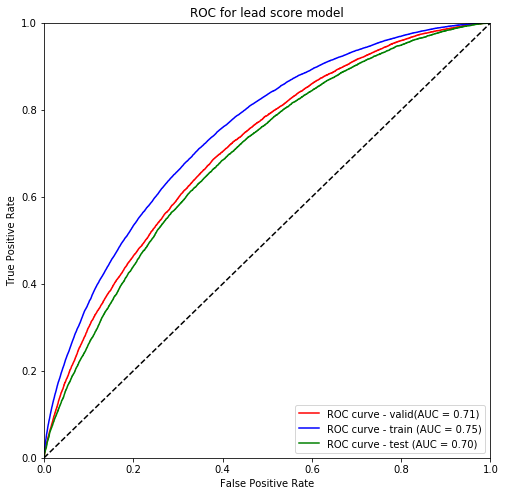

In [116]:
draw_ROC(gbm, dtrain, dvalid, dtest, y_train, y_valid, y_test)

In [117]:
y_pred = gbm.predict(dtest)

In [118]:
print y_pred.max(), y_pred.min(), y_pred.mean()

0.79729 0.00555161 0.168296


In [119]:
importance=gbm.get_fscore()

In [120]:
df_importance = pd.DataFrame(importance.items(), columns=['feature', 'fscore'])
df_importance['fscore'] = df_importance['fscore'] / df_importance['fscore'].sum()

In [121]:
df_importance.sort_values(['fscore'], ascending=False, inplace=True)
df_importance

,feature,fscore
25,installment,0.030167
64,dti,0.028382
84,zipcode,0.027795
14,maxbalbc,0.024813
63,intrate,0.024397
29,annualinc,0.023933
27,avgcurbal,0.023395
23,loanamnt,0.023028
28,mosinoldilacct,0.022344
13,tothicredlim,0.022271


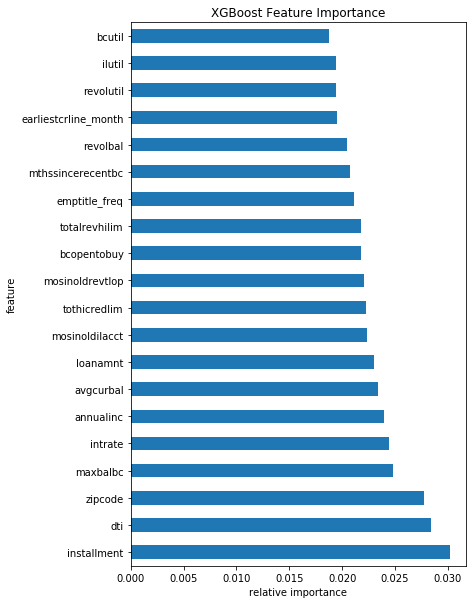

In [122]:
plt.figure(figsize=(32, 32))
# df_importance.plot()
df_importance[:20].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('feature_importance_xgb.png')

## Save model

In [123]:
import pickle

In [124]:
with open('model.pkl','wb') as pkl_file:
    pickle.dump(gbm, pkl_file)

In [125]:
from sklearn.externals import joblib
joblib.dump(gbm, "pima.joblib.dat")

['pima.joblib.dat']